#  NITF Replacement Sensor Model (RSM) Demo

This notebook demonstrates how to create an RSM TRE for a given image.  

## Benefits of the RSM over "4-corners" and SENSRB

1. No knowledge of the underlying camera is required.  The embedded polynomials abstract everything.
2. The imagery provider (You), no longer need to actually ortho-rectify the imagery.  Simply convert the imagery to the expected color-space, apply any color corrections, then write to disk.  The RSM can allow a downstream user to optionally apply ortho-rectification.

## Step 0 - Setup Preconditions

First, we have our required Python packages.

In [1]:
import datetime
import glob
import logging
import os
import sys

from urllib.request import urlopen

import pandas as pd

import cv2

import numpy as np

import plotly.graph_objects as go
import plotly.express       as px
import plotly.subplots      as sp

from tqdm import notebook as tqdm

sys.path.append( '../src' )
import tmns.net.wms as wms
import tmns.proj.RPC00B as RPC00B

Prepare a logger.

In [2]:
logging.basicConfig( level = logging.INFO )
logger = logging.getLogger( 'NITF RSM Demo' )

Our image is from April 23, 2002.

In [3]:
img_path = 'ARUDEN000040045.tif'

If you have already run this model, you can skip the WMS and GCP checks to save time and disk space.

In [4]:
overwrite_crops = False

We will be verifying our Ground Control Points via a comparison against USDA NAIP imagery.  This is available from the US Government via a Web-Map-Service (WMS).

In [5]:
#  URL to ArcGIS Hosted NAIP imagery
wms_url = 'https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?service=WMS'

# USDA_CONUS_PRIME
wms_layers = ['0']

#  Image Format
wms_format = 'image/png'

## Step 1 - Load Non-Orthorectified Image
In this demo, we have an aerial photograph of Denver's City Park taken in 2002.  This photo is used because it is not orthorectified.  We will need to manually determine a camera model.

In [6]:
img_bands = cv2.cvtColor( cv2.imread( img_path, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
print(img_bands.shape)

(2964, 2829, 3)


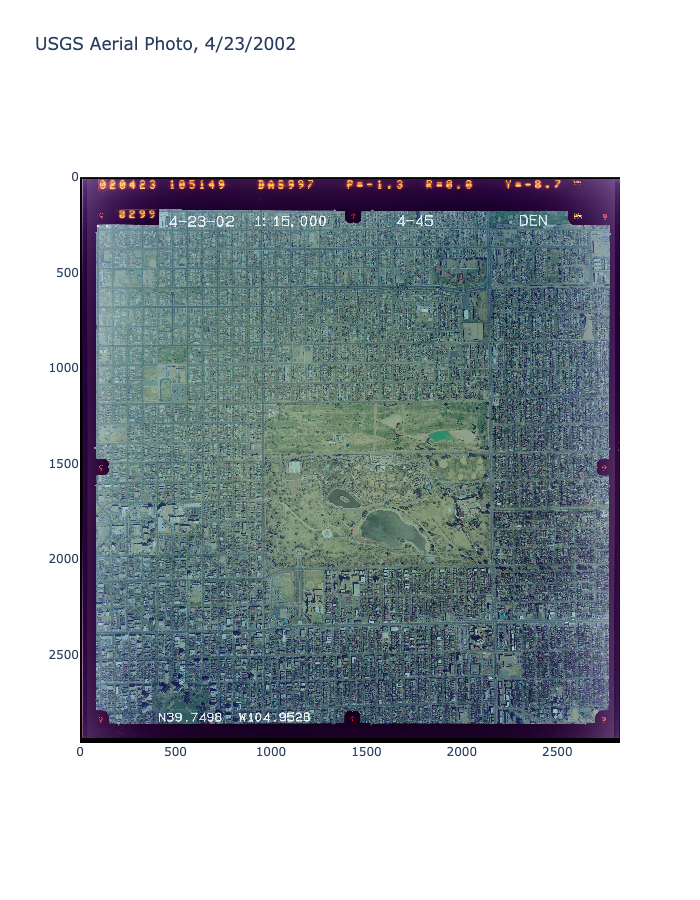

In [7]:
fig1 = go.Figure()
fig1.add_trace( go.Image( z = img_bands ) )
fig1.update_layout( title = 'USGS Aerial Photo, 4/23/2002',
                    height = 900 )
fig1.show( renderer = 'png' )

## Estimating Rigid Sensor Model

For this exerciese, we use the available metadata from the USGS for the given frame. 

In [8]:
img_df = pd.DataFrame( { 'Attribute': ['Acquisition Date', 'Flight Altitude (ft)', 'Focal Length (mm)',
                                       'Film Width (mm)', 'Film Height (mm)',
                                       'Center Lat', 'Center Lon',
                                       'NW Lat', 'NW Lon', 'NE Lat', 'NE Lon',
                                       'SE Lat', 'SE Lon', 'SW Lat', 'SE Lon',
                                       'Pitch Angle', 'Yaw Angle', 'Roll Angle' ],
                         'Value': [ datetime.datetime( year = 2002, month = 4, day = 23 ),
                                    7500, 152.77, 229, 229,
                                    39.750006, -104.95283,
                                    39.765563, -104.972699, 39.765335, -104.932675,
                                    39.734448, -104.932979, 39.734676, -104.972985,
                                    -1.3, -8.7, 0.0 ] } )
display( img_df )

,Attribute,Value
0,Acquisition Date,2002-04-23 00:00:00
1,Flight Altitude (ft),7500
2,Focal Length (mm),152.77
3,Film Width (mm),229
4,Film Height (mm),229
5,Center Lat,39.750006
6,Center Lon,-104.95283
7,NW Lat,39.765563
8,NW Lon,-104.972699
9,NE Lat,39.765335


We will assume the aircraft position is directly above the center point.  Given the camera rotation is not perfectly level, this will require adjustments later. 

In [9]:
position_lla = [ img_df.loc[img_df['Attribute'] == 'Center Lon'].values[0][1],
                 img_df.loc[img_df['Attribute'] == 'Center Lat'].values[0][1],
                 img_df.loc[img_df['Attribute'] == 'Flight Altitude (ft)'].values[0][1] * 3.28084]
display( position_lla )

[-104.95283, 39.750006, 24606.3]

## Mark Ground Control Points

We have a set of Ground-Control-Points in the attached file. The first few are shown for context.

In [10]:
gcp_df = pd.read_csv( 'GCPs.csv' )
mean_elevation = gcp_df['Elevation'].mean()
gcp_df['Elevation'] = mean_elevation
display( gcp_df.head(5) )
display( f'Total of {gcp_df.shape[0]} GCPs loaded' )

,Name,PX,PY,Latitude,Longitude,Elevation
0,Thatcher Fountain,1149,1971,39.744825,-104.956856,1609.6
1,31st and Gilpin,486,677,39.760815,-104.967139,1609.6
2,29th and Gilpin,478,876,39.758338,-104.967319,1609.6
3,26th and Williams,555,1179,39.754582,-104.966093,1609.6
4,21st and Franklin,398,1696,39.748303,-104.968554,1609.6


'Total of 25 GCPs loaded'

### Verifying Accuracy of GCPs
This is a highly error prone process.  To verify all inputs, we have a set of steps. 

- Verify the pixel locations by drawing a circle on the image and cropping.
- Verify the geographic coordinate by cropping a Web-Map-Service frame.
- Writing both images and showing.

In [11]:
def crop_and_mark_image( id, image, pix, crop_size ):

    # Define image path
    img_path = f'./crops/gcp_{id}_pixel_{pix[0]}_{pix[1]}.jpg'
    if overwrite_crops == False and os.path.exists( img_path ):
        return
    
    #  Crop the image
    r = [[max( 0, pix[1] - crop_size[0]), 
          min( image.shape[0]-1, pix[1] + crop_size[0])],
         [max( 0, pix[0] - crop_size[1]),
          min( image.shape[1]-1, pix[0] + crop_size[1])]]

    center = [ min( pix[1], crop_size[0] ),
               min( pix[0], crop_size[1] ) ]
    
    new_img = image[ r[0][0]:r[0][1], r[1][0]:r[1][1], : ]
    new_img = cv2.cvtColor( new_img, cv2.COLOR_RGB2BGR )

    #  Draw a circle
    new_img = cv2.circle( new_img, center, 10, (0, 0, 255 ), 3 )

    #  Write to disk
    cv2.imwrite( img_path, new_img )
    

In [12]:
def crop_wms_coord( id, lla ):

    output_path = f'./crops/gcp_{id}_lla.tif'
    if overwrite_crops == False and os.path.exists( output_path ):
        return
        
    wms_inst = wms.WMS( url          = wms_url,
                        epsg_code    = 32613,
                        center_ll    = lla,
                        win_size_pix = [400,400],
                        gsd          = 0.7,
                        layers       = wms_layers,
                        format       = wms_format )
    url = wms_inst.get_map_url()
    tif_bytes = urlopen(url).read()

    with open( output_path, 'wb' ) as fout:
        fout.write( tif_bytes )

    tmp_img = cv2.imread( output_path, cv2.IMREAD_COLOR )
    tmp_img = cv2.circle( tmp_img, [200,200], 10, (0, 0, 255 ), 3 )
    cv2.imwrite( output_path, tmp_img )
    

In [13]:
if not os.path.exists( 'crops' ):
    os.system( 'mkdir crops' )

pbar = tqdm.tqdm( total = gcp_df.shape[0] )
index = 0
for gcp in gcp_df.itertuples():

    pix = np.array( [ gcp.PX, gcp.PY ], dtype = np.int32 )
    lla = np.array( [ gcp.Longitude, gcp.Latitude, gcp.Elevation ], dtype = np.float64 )

    #  Crop scene
    crop_and_mark_image( index, img_bands, pix, crop_size = [200,200] )
    crop_wms_coord( index, lla )
    
    index += 1
    pbar.update( 1 )

  0%|          | 0/25 [00:00<?, ?it/s]

In [14]:

pbar = tqdm.tqdm( total = gcp_df.shape[0] )
for ID in range( 0, gcp_df.shape[0] ):

    fig2 = sp.make_subplots( rows = 1, cols = 2 )
    
    img1 = cv2.imread( glob.glob( f'./crops/gcp_{ID}_pixel*' )[0], cv2.IMREAD_COLOR )
    img2 = cv2.imread( glob.glob( f'./crops/gcp_{ID}_lla*' )[0], cv2.IMREAD_COLOR )

    fig2.add_trace( go.Image( z = img1 ), row = 1, col = 1 )
    fig2.add_trace( go.Image( z = img2 ), row = 1, col = 2 )
    fig2.update_layout( title = f'GCP {ID} Analysis, Pixel vs LLA',
                        height = 600 )
    fig2.write_image( f'./crops/gcp_{ID}_merged.jpg' )
    pbar.update(1)

  0%|          | 0/25 [00:00<?, ?it/s]

## Construct a System of Linear Equation

The core operation is for the World-to-Pixel projection. 

$$
H_\texttt{scale} = 
$$
Assuming $P$, $L$, and $H$, where

$$\frac{L - L_\texttt{scale}}{L}$$


In [15]:
class Rectangle:

    def __init__( self, point ):

        self.min_pnt = point
        self.size    = np.zeros( len(point), np.float64 )

        self.sum_pnt = np.copy(point)
        self.cnt_pnt = 1
        
    def min_point(self):
        return self.min_pnt

    def max_point(self):
        return self.min_pnt + self.size

    def mean_point(self):
        return self.sum_pnt / self.cnt_pnt
    
    def add_point(self, new_point ):

        min_delta = new_point - self.min_point()
        max_delta = new_point - self.max_point()

        self.sum_pnt += new_point
        self.cnt_pnt += 1

        for x in range( 0, len( new_point ) ):
            if min_delta[x] < 0:
                self.min_pnt[x] = new_point[x]
                self.size[x]   += abs(min_delta[x])
            elif max_delta[x] > 0:
                self.size[x] += abs(max_delta[x])
        

    def __str__(self):
        output  =  'Rectangle:\n'
        output += f' - min_point: {self.min_point()}\n'
        output += f' - max_point: {self.max_point()}\n'
        output += f' - sum_point: {self.sum_pnt}'
        return output

In [16]:
def compute_bboxes( gcps ):

    #  Compute bounding box
    pix_bbox = None
    lla_bbox = None

    for gcp in gcp_df.itertuples():

        pix = np.array( [ gcp.PX, gcp.PY ], dtype = np.int32 )
        lla = np.array( [ gcp.Longitude, gcp.Latitude, gcp.Elevation ], dtype = np.float64 )
        
        if pix_bbox is None:
            pix_bbox = Rectangle( pix )
        else:
            pix_bbox.add_point( pix )
            
        if lla_bbox is None:
            lla_bbox = Rectangle( lla )
        else:
            lla_bbox.add_point( lla )

    return pix_bbox, lla_bbox

In [17]:
def solve( gcp_df ):

    pix_bbox, lla_bbox = compute_bboxes( gcp_df )

    #  Get the mean of the points
    lla_gnd_mean = lla_bbox.mean_point()
    pix_mean = pix_bbox.mean_point()

    logger.info( f'Mean LLA Ground Coordinate: {lla_gnd_mean}' )
    logger.info( f'Mean Pixel Coordinates: {pix_mean}' )

    adj_pixels = []
    adj_gnd_lla = []

    max_delta_lla = np.zeros( len(lla_bbox.size) )
    
    for gcp in gcp_df.itertuples():

        #  Create nparray point
        pix = np.array( [ gcp.PX, gcp.PY ], dtype = np.int32 )
        lla = np.array( [ gcp.Longitude, gcp.Latitude, gcp.Elevation ], dtype = np.float64 )

        #  Adjust point from mean
        d_lla = ( lla - lla_bbox.mean_point() )
        d_pix = ( pix - pix_bbox.mean_point() ) / ( pix_bbox.size / 2.0 )

        #  Update our maximum delta
        max_delta_lla = np.maximum( max_delta_lla, np.abs( d_lla ) )

        #  Append point to list of deltas
        adj_gnd_lla.append( d_lla )
        adj_pixels.append( d_pix )

    logger.info( f'Max LLA Delta: {max_delta_lla}' )

    # Prevent division by zero
    if max_delta_lla[2] < 1:
        max_delta_lla[2] = 1
    

    #  Normalize points
    norm_gnd_lla = []
    for x in range( len( adj_gnd_lla ) ):
        for idx in range( len( max_delta_lla ) ):
            norm_gnd_lla.append( adj_gnd_lla[x] / max_delta_lla[idx] )

    #  Setup model
    model = RPC00B.from_components( pix_bbox.mean_point(),
                                    lla_bbox.mean_point(),
                                    pix_bbox.size[0],
                                    pix_bbox.size[1],
                                    max_delta_lla )

    logger.info( model )

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
solve( gcp_df )

INFO:NITF RSM Demo:Mean LLA Ground Coordinate: [-104.95 39.75 1609.60]
INFO:NITF RSM Demo:Mean Pixel Coordinates: [1389.40 1406.28]
INFO:NITF RSM Demo:Max LLA Delta: [0.02 0.02 0.00]


AttributeError: module 'tmns.proj.RPC00B' has no attribute 'from_components'